In [264]:
options(repr.matrix.max.cols=50)

In [265]:
wd <- dirname(dirname(getwd()))
source(paste0(wd,"/mission_control/treasure_map.R"))
source(paste0(wd,"/mission_control/helpers/figures/figure5_themes.R"))

library(tidyverse)
library(gridExtra)
library(ggpubr)
library(patchwork)

- Read the data

In [266]:
meta <- readRDS(paste0(TMP_DIR, "validation-hmf-go.Rds")) %>% drop_na(tcell) %>% select(patient_id, tissue_full) 
hmf <- readRDS(paste0(TMP_DIR, "validation-loo-cv.Rds"))
non_hmf <- readRDS(paste0(TMP_DIR, "validation-non-cpi.Rds"))

- Let's go!

In [267]:
hmf_go <- ( meta 
      %>% inner_join( hmf, by = "patient_id")
      %>% transmute( cpi = TRUE, lr_gp, tissue_full))
go <- rbind( hmf_go, non_hmf %>% transmute(cpi, lr_gp, tissue_full))
go <- go  %>% filter(tissue_full != "lymphoid_tissue")

In [268]:
o_dir <- paste0(FIG_DIR ,"supplement_main/")

In [269]:
namer <- function(i){str_to_title(paste0(strsplit(i, "_")[[1]], collapse = " "))}
go$tissue_full <- unlist(lapply(as.character(go$tissue_full), function(i) namer(i)))
go$tissue_full <- ifelse(go$cpi, paste0(" ", go$tissue_full), go$tissue_full)

In [270]:
base <- ( go 
    %>% group_by(tissue_full, cpi) 
    %>% mutate(ct = n())
    %>% ungroup()
    %>% mutate(tissue_gp = ifelse(ct < 15, "Other", tissue_full))
)

In [271]:
top <- base %>%
    group_by(tissue_gp, lr_gp, cpi) %>% 
    summarize(tot = n())
bottom <- base %>% 
    filter(tissue_gp == "Other") %>%
    group_by(tissue_full, lr_gp, cpi) %>% 
    summarize(tot = n())

`summarise()` has grouped output by 'tissue_gp', 'lr_gp'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'tissue_full', 'lr_gp'. You can override using the `.groups` argument.


In [272]:
top_counts = base  %>% group_by(tissue_gp)  %>% count(name = "n_samples")
bottom_counts = base  %>% group_by(tissue_full)  %>% count(name = "n_samples")

In [273]:
top = left_join(top, top_counts, by = "tissue_gp")
bottom = left_join(bottom, bottom_counts, by = "tissue_full")

### Plots go

In [274]:
top  = top  %>% 
    mutate(cpi_go = case_when(cpi ~ "CPI",
                             !cpi & n_samples > 50 ~ "Non-CPI (>50 samples)", 
                             !cpi & n_samples < 50 ~ "Non-CPI (<50 samples)"))  %>% 
    mutate(cpi_go = factor(cpi_go, levels = c("CPI", "Non-CPI (>50 samples)", "Non-CPI (<50 samples)")))
top <- top %>% group_by(cpi) %>% arrange(tot)

bottom$cpi_go <- ifelse(bottom$cpi, "CPI", "Non-CPI")
bottom <- bottom %>% group_by(cpi) %>% arrange(tot)

In [275]:
idx_top <- top %>% arrange(tissue_gp) %>% group_by(tissue_gp) %>% summarise(ct = sum(tot)) %>% arrange(ct) %>% pull(tissue_gp)
idx_bottom <- bottom %>% arrange(tissue_full) %>% group_by(tissue_full) %>% summarise(ct = sum(tot)) %>% arrange(ct) %>% pull(tissue_full)

In [276]:
idx_top <- c("Other", idx_top[-which(idx_top == "Other")])

In [277]:
top <- top %>% 
    mutate(tissue_gp = factor(tissue_gp, levels = idx_top), tot_rnd = tot)

In [278]:
dist_plotter <- function(df, gp = "tissue_gp", title = "Predicted CPI Response Groups\nNumber of patients") {
    (
    ggplot(data = df, aes_string(y= gp, x="tot", fill = "lr_gp", label = "tot_rnd"), colour="black", stat="identity") 
    + geom_bar(stat="identity", width=.9, position = 'stack', colour = "black", size = .1, alpha = 0.9) 
    + scale_fill_manual(values = c('Low' = my_palette[1],'Medium' = my_palette[2],'High' = my_palette[3]))    
    + geom_text(size = 3.5, position = position_stack(vjust = .5))
    + theme_classic()
    + ggh4x::facet_grid2(cpi_go ~ ., scales = "free",  independent = "x", space = "free_y")
    + labs(y = "Primary Tissue\n", xlab = NULL) 
    + theme(plot.title = element_text(hjust = 0.5))
    + ggtitle(title)
    )
}

In [279]:
top = top  %>%  mutate(tot_rnd = tot)
bottom = bottom  %>%  mutate(tot_rnd = tot)
top_rel = top  %>% group_by(tissue_gp,  cpi_go)  %>% 
    mutate(tot = tot/sum(tot)*100, 
          tot_rnd = round(tot/sum(tot),2)*100)

In [280]:
go_top <- dist_plotter(top, gp = "tissue_gp") +  xlab("Number of patients") + 
 theme(strip.background = element_blank(),
       strip.text.y = element_blank())

In [281]:
# bottom plot: 
bottom = bottom  %>% mutate(cpi_label = ifelse(cpi, "CPI (<15 samples)", "Non-CPI (<15 samples)"))
plt_bottom = ggplot(data = bottom, aes(y= tissue_full, x=tot, fill = lr_gp), 
                colour="black") +
    geom_bar(stat="identity", width=.9, position = 'stack', colour = "black", size = .1,  alpha = 0.9)  + 
    geom_text(aes(label = tot_rnd),size = 3.5, position = position_stack(vjust = .5)) +
    lemon::facet_rep_grid(cpi_label ~ ., space = "free_y", scale = "free", repeat.tick.labels = TRUE) + 
    theme_classic() + 
    scale_x_continuous(limits = c(0, 15)) + 
    scale_fill_manual(values = c('Low' = my_palette[1],'Medium' = my_palette[2],'High' = my_palette[3]))  + 
    theme(strip.background = element_rect(fill = "grey80", color = "white")) + 
    labs(y = "Primary Tissue\n", x = "Number of patients") + 
    ggtitle("")

In [282]:
top_rel_plt = dist_plotter(top_rel, gp = "tissue_gp", title = "Predicted CPI Response Groups\nPercentage") + 
    xlab("Percentage of patients") + ylab(NULL) + 
    theme(axis.text.y = element_blank(), legend.position = "none", strip.background = element_rect(fill = "grey80", color = "white"))

In [283]:
options(repr.plot.width = 12, repr.plot.height = 12)
total_plot = wrap_plots(go_top, top_rel_plt, plt_bottom, guide_area()) + plot_layout(guides = "collect", widths = c(1,0.6), heights = c(1.25,1))

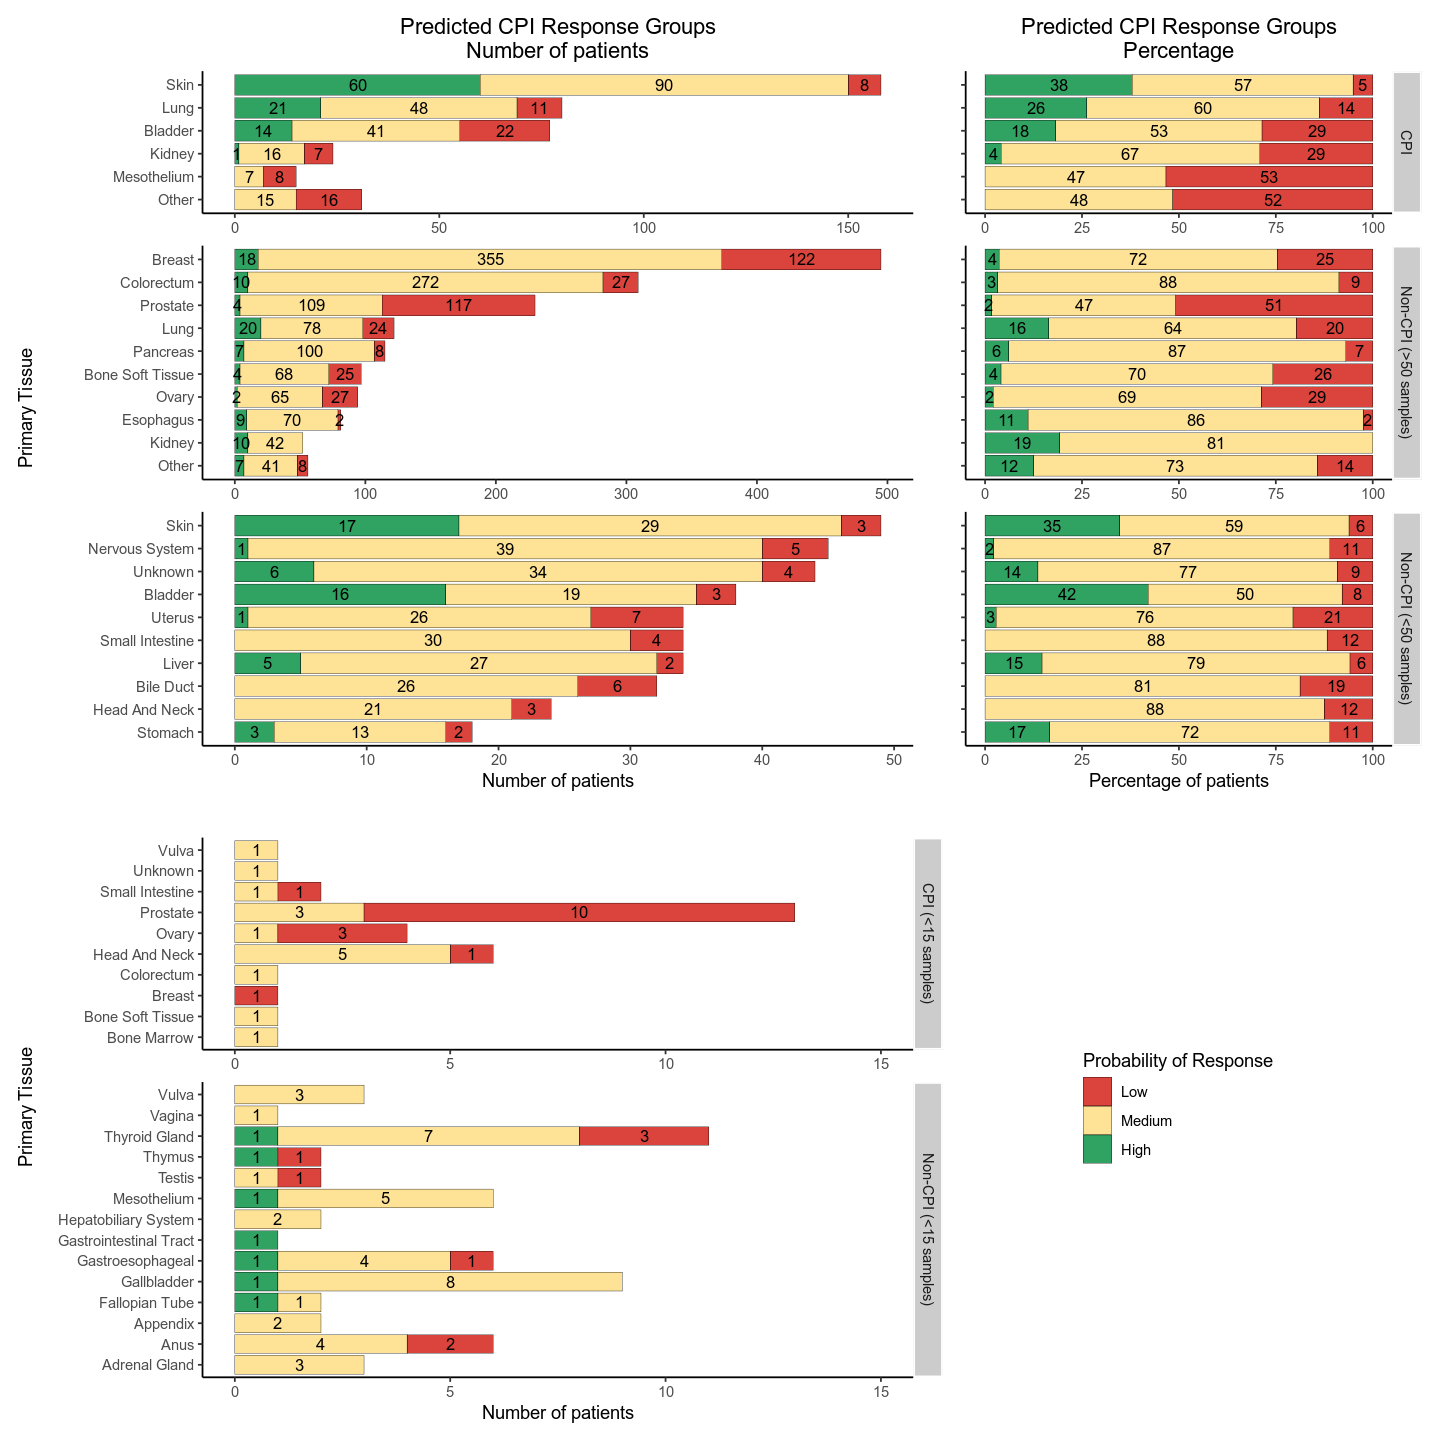

In [ ]:
total_plot & labs(fill = "Probability of Response")

In [285]:
ggsave(paste0(FIG_FINAL_DIR, "3_supplement_main_hmf_non_cpi_preds_Axel.png"), width = 10, height = 10, dpi = 500)